In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import random
import time
import torch
from PIL import Image
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BlipProcessor, BlipForConditionalGeneration
from tqdm import tqdm
from prettytable import PrettyTable
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# ---------- إعدادات ----------
DATA_DIR = '/content/drive/MyDrive/Resized_Images/Resized_Images1'
CAPTIONS_FILE = '/content/drive/MyDrive/Flickr8k/captions.txt'
CHECKPOINT_DIR = '/content/drive/MyDrive/Checkpoints1'
EPOCHS = 1          # عدد الإيبوك
BATCH_SIZE = 3      # حجم الباتش
SAVE_EVERY = 50     # حفظ كل 50 خطوة
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# ---------- تحميل المعالج والنموذج ----------
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# ---------- Dataset ----------
class ImageCaptionDataset(Dataset):
    def __init__(self, images_dir, captions_file, processor):
        self.data = []
        self.processor = processor

        image_captions = defaultdict(list)
        with open(captions_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()[1:]  # حذف أول سطر إذا كان header
            for line in lines:
                parts = line.strip().split(',', 1)
                if len(parts) != 2:
                    continue
                image_name, caption = parts
                image_captions[image_name.strip()].append(caption.strip())

        for image_name, captions in image_captions.items():
            if len(captions) >= 2:
                image_path = os.path.join(images_dir, image_name)
                self.data.append((image_path, captions))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, captions = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        # اختيار وصفين عشوائيين ودمجهم
        chosen_captions = random.sample(captions, 2)
        combined_caption = " . ".join(chosen_captions)

        inputs = self.processor(
            text=combined_caption,
            images=image,
            padding='max_length',
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        pixel_values = inputs["pixel_values"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values,
            "caption_text": combined_caption,
            "image_path": image_path
        }

In [ ]:
# ---------- DataLoader ----------
dataset = ImageCaptionDataset(DATA_DIR, CAPTIONS_FILE, processor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
import os
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from torch.optim import AdamW
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration

# ---------- إعدادات ----------
CHECKPOINT_DIR = '/content/drive/MyDrive/Checkpoints1'
EPOCHS = 1
SAVE_EVERY = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- تحميل أو استئناف ----------
resume_from = None
if os.path.exists(CHECKPOINT_DIR) and len(os.listdir(CHECKPOINT_DIR)) > 0:
    ckpts = sorted(os.listdir(CHECKPOINT_DIR))
    resume_from = os.path.join(CHECKPOINT_DIR, ckpts[-1])  # آخر Checkpoint

    print(f"🔄 استئناف التدريب من {resume_from}")

    # تحميل النموذج والمعالج
    model = BlipForConditionalGeneration.from_pretrained(resume_from).to(DEVICE)
    processor = BlipProcessor.from_pretrained(resume_from)

    # تحميل Optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)
    opt_path = os.path.join(resume_from, "optimizer.pt")
    if os.path.exists(opt_path):
        optimizer.load_state_dict(torch.load(opt_path, map_location=DEVICE))

    # تحديد آخر step
    try:
        last_step = int(resume_from.split("-")[-1])
    except:
        last_step = 0
else:
    print("🚀 بدء تدريب جديد من الصفر")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(DEVICE)
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    optimizer = AdamW(model.parameters(), lr=5e-5)
    last_step = 0

# ---------- Training ----------
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
results = []
step = last_step
total_steps = EPOCHS * len(dataloader)
start_time = time.time()

print(f"⏳ بدء التدريب: {EPOCHS} Epoch, {total_steps} خطوات إجمالية (ابتداءً من {step})")

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    model.train()

    for batch in dataloader:
        step += 1

        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        pixel_values = batch["pixel_values"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            labels=input_ids
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # حساب accuracy بدون padding
        preds = torch.argmax(outputs.logits, dim=-1)
        mask = attention_mask.bool()
        correct = (preds[mask] == input_ids[mask]).float().sum()
        acc = correct / mask.sum()

        # الوقت المتبقي
        elapsed = time.time() - start_time
        steps_left = total_steps - step
        eta = time.strftime("%H:%M:%S", time.gmtime(elapsed / step * steps_left))

        # تخزين النتائج
        results.append({
            "Step": step,
            "Epoch": epoch+1,
            "Loss": loss.item(),
            "Accuracy": acc.item(),
            "ETA": eta
        })

        # جدول كل 10 خطوات
        if step % 10 == 0 or step == total_steps:
            table = PrettyTable()
            table.field_names = ["Step", "Epoch", "Loss", "Acc", "ETA"]
            for row in results[-10:]:
                table.add_row([
                    row["Step"],
                    row["Epoch"],
                    f"{row['Loss']:.4f}",
                    f"{row['Accuracy']:.4f}",
                    row["ETA"]
                ])
            print(table)

        # حفظ Checkpoint
        if step % SAVE_EVERY == 0:
            ckpt_path = os.path.join(CHECKPOINT_DIR, f"checkpoint-{step}")
            model.save_pretrained(ckpt_path)
            processor.save_pretrained(ckpt_path)
            torch.save(optimizer.state_dict(), os.path.join(ckpt_path, "optimizer.pt"))

            # حذف القديم والإبقاء على آخر واحد فقط
            ckpts = sorted(os.listdir(CHECKPOINT_DIR))
            for old in ckpts[:-1]:
                os.system(f"rm -rf {os.path.join(CHECKPOINT_DIR, old)}")



🔄 استئناف التدريب من /content/drive/MyDrive/Checkpoints1/checkpoint-2600
⏳ بدء التدريب: 1 Epoch, 2697 خطوات إجمالية (ابتداءً من 2600)

--- Epoch 1/1 ---
+------+-------+--------+--------+----------+
| Step | Epoch |  Loss  |  Acc   |   ETA    |
+------+-------+--------+--------+----------+
| 2601 |   1   | 0.3358 | 0.0247 | 00:00:03 |
| 2602 |   1   | 0.2518 | 0.0455 | 00:00:04 |
| 2603 |   1   | 0.4282 | 0.0345 | 00:00:05 |
| 2604 |   1   | 0.2790 | 0.0370 | 00:00:06 |
| 2605 |   1   | 0.4016 | 0.0366 | 00:00:07 |
| 2606 |   1   | 0.3071 | 0.0375 | 00:00:09 |
| 2607 |   1   | 0.3908 | 0.0395 | 00:00:10 |
| 2608 |   1   | 0.3094 | 0.0400 | 00:00:11 |
| 2609 |   1   | 0.4967 | 0.0357 | 00:00:12 |
| 2610 |   1   | 0.2923 | 0.0484 | 00:00:13 |
+------+-------+--------+--------+----------+
+------+-------+--------+--------+----------+
| Step | Epoch |  Loss  |  Acc   |   ETA    |
+------+-------+--------+--------+----------+
| 2611 |   1   | 0.4035 | 0.0337 | 00:00:14 |
| 2612 |   1   | 0.

KeyboardInterrupt: 

📂 تحميل النموذج من: /content/drive/MyDrive/Checkpoints1/checkpoint-2700

📝 القصة المولدة:
a group of people stand on a brick sidewalk and look at something in the distance as others stand in line to take pictures of something


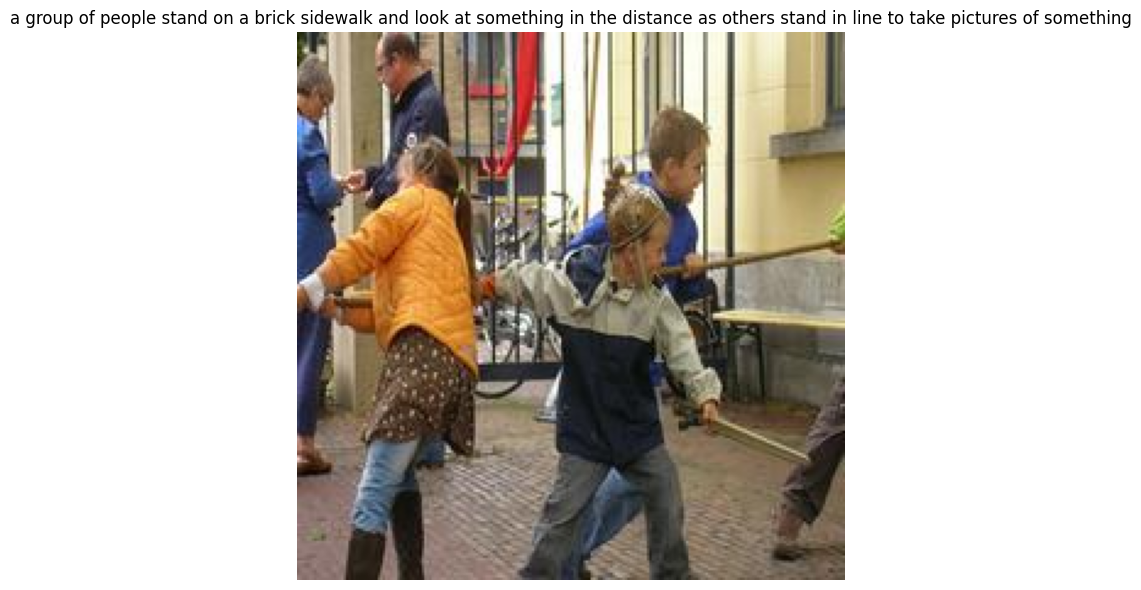


✅ الصورة مع القصة محفوظة في: /content/drive/MyDrive/Checkpoints1/test_image_with_story.png


In [ ]:

import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration

# ---------- إعداد ----------
CHECKPOINT_DIR = "/content/drive/MyDrive/Checkpoints1"
image_path = "/content/drive/MyDrive/Resized_Images/Resized_Images1/494907021_321e82877a.jpg"  # حطي مسار صورتك هنا

# آخر مجلد شيكبوينت فقط
ckpts = sorted([c for c in os.listdir(CHECKPOINT_DIR) if c.startswith("checkpoint-")])
if len(ckpts) == 0:
    raise ValueError("⚠️ ما في أي مجلد Checkpoint!")

last_ckpt = os.path.join(CHECKPOINT_DIR, ckpts[-1])
print("📂 تحميل النموذج من:", last_ckpt)

# ---------- تحميل النموذج والمعالج ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipForConditionalGeneration.from_pretrained(last_ckpt).to(device)
processor = BlipProcessor.from_pretrained(last_ckpt)

# ---------- قراءة الصورة ----------
image = Image.open(image_path).convert("RGB")

# ---------- تجهيز الإدخال وتوليد القصة ----------
inputs = processor(images=image, return_tensors="pt").to(device)
output_ids = model.generate(**inputs, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
story = processor.decode(output_ids[0], skip_special_tokens=True)

print("\n📝 القصة المولدة:")
print(story)

# ---------- عرض الصورة مع القصة ----------
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.title(story, fontsize=12)
plt.tight_layout()
plt.show()

# ---------- حفظ الصورة مع القصة للتوثيق ----------
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image)
ax.axis('off')
ax.set_title(story, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_image_with_story.png"), bbox_inches='tight')
plt.close()

print(f"\n✅ الصورة مع القصة محفوظة في: {os.path.join(CHECKPOINT_DIR, 'test_image_with_story.png')}")


📂 تحميل النموذج من: /content/drive/MyDrive/Checkpoints1/checkpoint-2700

📝 القصة المولدة:
a silver sports car drives down a winding road with a cliff in the background on either side of it


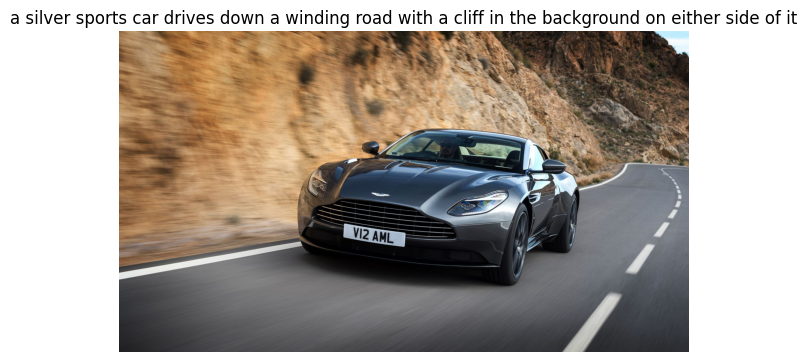


✅ الصورة مع القصة محفوظة في: /content/drive/MyDrive/Checkpoints1/test_image_with_story.png


In [ ]:


import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration

# ---------- إعداد ----------
CHECKPOINT_DIR = "/content/drive/MyDrive/Checkpoints1"
image_path = "/content/drive/MyDrive/Checkpoints1/9182.jpg"  # حطي مسار صورتك هنا

# آخر مجلد شيكبوينت فقط
ckpts = sorted([c for c in os.listdir(CHECKPOINT_DIR) if c.startswith("checkpoint-")])
if len(ckpts) == 0:
    raise ValueError("⚠️ ما في أي مجلد Checkpoint!")

last_ckpt = os.path.join(CHECKPOINT_DIR, ckpts[-1])
print("📂 تحميل النموذج من:", last_ckpt)

# ---------- تحميل النموذج والمعالج ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipForConditionalGeneration.from_pretrained(last_ckpt).to(device)
processor = BlipProcessor.from_pretrained(last_ckpt)

# ---------- قراءة الصورة ----------
image = Image.open(image_path).convert("RGB")

# ---------- تجهيز الإدخال وتوليد القصة ----------
inputs = processor(images=image, return_tensors="pt").to(device)
output_ids = model.generate(**inputs, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
story = processor.decode(output_ids[0], skip_special_tokens=True)

print("\n📝 القصة المولدة:")
print(story)

# ---------- عرض الصورة مع القصة ----------
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.title(story, fontsize=12)
plt.tight_layout()
plt.show()

# ---------- حفظ الصورة مع القصة للتوثيق ----------
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image)
ax.axis('off')
ax.set_title(story, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_image_with_story.png"), bbox_inches='tight')
plt.close()

print(f"\n✅ الصورة مع القصة محفوظة في: {os.path.join(CHECKPOINT_DIR, 'test_image_with_story.png')}")
